In [15]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings

warnings.filterwarnings("ignore")

In [16]:
class Model(nn.Module):
     
    def __init__(self, N):
        super().__init__()
        self.N = N
        self.stepLength = 2
        
        self.layer1 = nn.Linear(1, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 1)
        
        self.layer4 = nn.Linear(2, 64)
        self.layer5 = nn.Linear(64, 64)
        self.layer6 = nn.Linear(64, 1)
  
    
    def forward1(self, x):
        """Approximate wave function"""
            
        y = torch.tanh(self.layer1(x))
        y = torch.tanh(self.layer2(y))
        y = self.layer3(y)
     
        return y
    
    def forward2(self, x2, x1):
        """Approximate wave function"""
        
        y = torch.cat((x2, x1), 1)
        y = torch.tanh(self.layer4(y))
        y = torch.tanh(self.layer5(y))
        y = self.layer6(y)
     
        return y
    
    
    def sample1(self, N, n):
        total = 0
        x = torch.Tensor(4*np.random.random((N,1)) - 2)
        psi_old = self.forward1(x)
        
        for i in range(n):
            x_new = x + self.stepLength*torch.Tensor(2*np.random.random((N,1)) - 1)
            psi_new = self.forward1(x_new)
            
            idx = (psi_new/psi_old)**2 > torch.Tensor(np.random.random((N,1)))
             
            x[idx] = x_new[idx]
            psi_old[idx] = psi_new[idx]
            total += torch.sum(idx)
            
        return x, total
    
    def sample2(self, N, n, x1):
        total = 0
        x = torch.Tensor(4*np.random.random((N,1)) - 2)
        psi_old = self.forward2(x, x1)
        
        for i in range(n):
            x_new = x + self.stepLength*torch.Tensor(2*np.random.random((N,1)) - 1)
            psi_new = self.forward2(x_new, x1)
            
            idx = (psi_new/psi_old)**2 > torch.Tensor(np.random.random((N,1)))
            
            
            x[idx] = x_new[idx]
            psi_old[idx] = psi_new[idx]
            total += torch.sum(idx)
            
        return x, total

In [17]:
N = 5000 #Batch size
n = 20  #Metropolis step
h = 0.01

torch.manual_seed(42)
np.random.seed(42)
model = Model(N)
optimizer = torch.optim.Adam(model.parameters())

### Training

In [18]:
epochs = 4000
energy = []

for epoch in tqdm(range(epochs)):
    PE_acc = 0
    P_acc = 0
    E_acc = 0
        
    x1 = model.sample1(N, n)[0].detach() #sample N positions for first particle
    psi1 = model.forward1(x1)
    
    x2 = model.sample2(N, n, x1)[0].detach() #Sample positions for second particle, corrolated with first particle
    psi2 = model.forward2(x2, x1)        
    
    psi_total = psi1*psi2               #Total wave function
    
    
    #Numerical laplacian
    psi1_plus = model.forward1(x1+h)   #Change particle 1 coordinate, holding particle 2 constant.            
    psi2_plus = model.forward2(x2, x1+h)  #however, psi2 still changes because of corrolation
    
    psi1_minus = model.forward1(x1-h)
    psi2_minus = model.forward2(x2, x1-h)

    lap1 = 1/psi_total*(psi1_plus*psi2_plus - 2*psi_total + psi1_minus*psi2_minus)/h**2
    
    psi2_plus = model.forward2(x2+h, x1) #Change particle 2 coordinate, holding particle 1 constant.
    psi2_minus = model.forward2(x2-h, x1)
    
    lap2 = 1/psi2*(psi2_plus - 2*psi2 + psi2_minus)/h**2    #psi1 factor here, since it is constant
    

    E_L = (-0.5*(lap1 + lap2) + 0.5*(x1**2 + x2**2) + 1/torch.sqrt((x1 - x2)**2 + 0.1**2)).detach()

    PE = torch.mean(psi_total/psi_total.detach()*E_L)
    P  = torch.mean(psi_total/psi_total.detach())
    E  = torch.mean(E_L)  
    
    loss = 2*(PE - P*E)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    energy.append(E.item())
    
    if epoch%100 == 0: 
        print(f"epoch: {epoch}, Energy: {E.item()}")

epoch: 0, Energy: 42.122413635253906
epoch: 100, Energy: 3.401301860809326
epoch: 200, Energy: 3.280672311782837
epoch: 300, Energy: 3.217418670654297
epoch: 400, Energy: 3.0890941619873047
epoch: 500, Energy: 3.093859910964966
epoch: 600, Energy: 3.0577645301818848
epoch: 700, Energy: 3.049659490585327
epoch: 800, Energy: 2.9329476356506348
epoch: 900, Energy: 2.9451775550842285
epoch: 1000, Energy: 3.6411941051483154
epoch: 1100, Energy: 2.9457743167877197
epoch: 1200, Energy: 3.0711300373077393
epoch: 1300, Energy: 2.7897841930389404
epoch: 1400, Energy: 2.791516065597534
epoch: 1500, Energy: 2.7703983783721924
epoch: 1600, Energy: 2.6975791454315186
epoch: 1700, Energy: 2.722041130065918
epoch: 1800, Energy: 2.893770217895508
epoch: 1900, Energy: 2.634640693664551
epoch: 2000, Energy: 2.6863577365875244
epoch: 2100, Energy: 2.6033592224121094
epoch: 2200, Energy: 2.610963821411133
epoch: 2300, Energy: 2.618511199951172
epoch: 2400, Energy: 2.712844133377075
epoch: 2500, Energy: 2.6

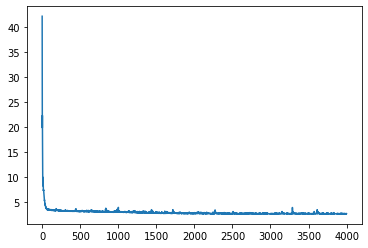

In [19]:
plt.plot(energy)
plt.show()

In [20]:
def f(x):
    x_lin = torch.linspace(-8, 8, 5000).reshape(5000,-1)
    dx = x_lin[1] - x_lin[0] 
    psi1 = model.forward1(x_lin)[:,0].detach().numpy()

    x = torch.Tensor([[x]]).repeat(5000,1)
    
    psi2 = model.forward2(x_lin, x)[:,0].detach().numpy()

    plt.plot(x_lin[:,0], 1/dx*psi1**2/np.sum(psi1**2), "b")
    plt.plot(x_lin[:,0], 1/dx*psi2**2/np.sum(psi2**2), "r")
    plt.plot(x[0], 0.01, "bo")
    plt.ylim((0, 0.8))

    plt.show()
    
interact(f, x=(-4.0, 4., 0.05));

interactive(children=(FloatSlider(value=0.0, description='x', max=4.0, min=-4.0, step=0.05), Output()), _dom_c…

### Check metropolis sampling

In [ ]:
N = 100000
x_lin = torch.linspace(-3, 3, 100).reshape(100,-1)
dx = x_lin[1] - x_lin[0]

x_a = torch.Tensor([[0.2]]).repeat(100,1)
x_b = torch.Tensor([[0.2]]).repeat(N,1)

psi = model.forward2(x_lin, x_a)[:,0].detach().numpy()

x = model.sample2(N, 20, x_b)[0].detach().numpy()

bins = np.linspace(-3, 3, 100)
plt.hist(x, bins=bins)
plt.plot(x_lin[:,0], N*psi**2/np.sum(psi**2), "r")
plt.show()

## Estimating energy

In [ ]:
N = 100000

x1 = model.sample1(N, n)[0].detach() #sample N positions for first particle
psi1 = model.forward1(x1)

x2 = model.sample2(N, n, x1)[0].detach() #Sample positions for second particle, corrolated with first particle
psi2 = model.forward2(x2, x1)        

psi_total = psi1*psi2               #Total wave function


#Numerical laplacian
psi1_plus = model.forward1(x1+h)   #Change particle 1 coordinate, holding particle 2 constant.            
psi2_plus = model.forward2(x2, x1+h)  #however, psi2 still changes because of corrolation

psi1_minus = model.forward1(x1-h)
psi2_minus = model.forward2(x2, x1-h)

lap1 = 1/psi_total*(psi1_plus*psi2_plus - 2*psi_total + psi1_minus*psi2_minus)/h**2

psi2_plus = model.forward2(x2+h, x1) #Change particle 2 coordinate, holding particle 1 constant.
psi2_minus = model.forward2(x2-h, x1)

lap2 = 1/psi2*(psi2_plus - 2*psi2 + psi2_minus)/h**2    #psi1 factor here, since it is constant


E = (-0.5*(lap1 + lap2) + 0.5*(x1**2 + x2**2) + 0/torch.sqrt((x1 - x2)**2 + 0.1**2)).detach()
E = torch.mean(E)
print(E)

x = torch.cat((x1, x2), 0).numpy()

In [ ]:
bins = np.linspace(-3, 3, 100)

plt.hist(x, bins=bins)
plt.show()